# Multiarmed bandits

In [1]:
import torch
import matplotlib.pyplot as plt

## K Armed Bandit implementation

This is a simple implementation of a K-Armed bandit environment.
It is implemented following the guidelines given in Chapter 2: Multi-armed Bandits of the book "Reinforcement Learning an introduction 2ed" section 2.3.

The true value q\*(a) of each of the K actions is selected according to a normal distribution with mean zero and unit variance, and then the actual rewards are selected according to a mean q\*(a) unit variance normal distribution.

The step method returns a reward an a new state to follow the conventions of Reinforcement Learning frameworks. However, for the K-Armed Bandit environment the states do not change, so it allways returns None.

In [2]:
class KArmedBandit:
    
    def __init__(self, k=10):
        self.k = k
        self.reset()
        
    def reset(self):
        '''Reset the environment. Creates new probability distributions for each arm.'''
        # probability distribution of the arm mean
        arms_mean_dist = torch.distributions.Normal(0, 1)
        
        # probability distribution of each arm reward
        self.arms = [torch.distributions.Normal(arms_mean_dist.sample((1,)), 1) for _ in range(self.k)]

    def step(self, action):
        '''Pull the specified arm and return the reward.'''

        arm = self.arms[action]
        reward = arm.sample((1,)).view((1,))
        
        return reward, None
    
    def state(self):
        return None

## Agents

### Random Agent
Will always play random actions

In [3]:
class RandomAgent:
    
    def reset(self):
        pass

    def play_action(self, env):
        action = torch.randint(env.k, (1,))
        reward, new_state = env.step(action)
        
        return action, reward, new_state

### Greedy agent
Will always play the best action known (the action with the highest estimated value).

To estimate the value of each action a list of received rewards and the number of times the action was selected is saved. The estimated value is computed as the average reward for each action. The action with the highest average reward is selected.

An epsilon parameter is supported to use an Epsilon-Greedy strategy. In this case there is a probability of epsilon that a random action will be selected, without taking into account the estimated rewards for each action, which encourages exploration of the different available actions.

In [4]:
class GreedyAgent:

    def __init__(self, k, epsilon=0.0):
        self._k = k
        self._epsilon = epsilon
        self.reset()
        
    def reset(self):
        self._actions_rewards = torch.empty(self._k)
        self._actions_count = torch.empty(self._k)
        self._steps = 0
    
    def play_action(self, env):      
        if not self._steps or torch.rand(1) < self._epsilon:
            # if this is the first step, or epsilon is in range: select random action
            action = torch.randint(self._k, (1,)).view((1,))
        else:
            # select best known action
            action = torch.argmax(self._actions_rewards/self._actions_count).view((1,))

        reward, new_state = env.step(action)
        
        self._actions_count[action] += 1
        self._actions_rewards[action] += reward
        
        self._steps += 1

        return action, reward, new_state

## The 10-armed Testbed
Comparison of different agents with different policies using a 10-Armed Bandit environment

In [5]:
def test_agent(agent, env, steps=1000, runs=2000):
    rewards = torch.empty((runs, steps))
    actions = torch.empty((runs, steps), dtype=torch.int32)

    for run in range(runs):
        agent.reset()
        env.reset()

        for step in range(steps):
            # select and play action
            action, reward, new_state = agent.play_action(env)
            
            # save action and reward
            actions[run][step] = action
            rewards[run][step] = reward
            
    return actions, rewards

Testing random agent
Testing greedy agent
Testing epsilon-greedy-0.1 agent
Testing epsilon-greedy-0.01 agent


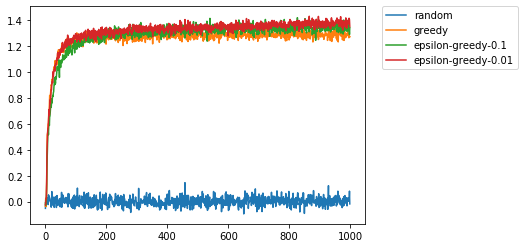

In [6]:
k = 10
env = KArmedBandit(k=k)

agents = {
    'random': RandomAgent(),
    'greedy': GreedyAgent(k),
    'epsilon-greedy-0.1': GreedyAgent(k, epsilon=0.1),
    'epsilon-greedy-0.01': GreedyAgent(k, epsilon=0.01),
}

actions = {}
rewards = {}

for name, agent in agents.items():
    print(f'Testing {name} agent')
    actions[name], rewards[name] = test_agent(agent, env)

for name, rews in rewards.items():
    mean_rewards = rews.mean(axis=0)
    plt.plot(torch.arange(mean_rewards.shape[0]), mean_rewards, label=name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()